# **Movie Ratings Analytics with PySpark**

# Setup in Google Colab

In [1]:
!pip install pyspark

# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Movie-Capstone").getOrCreate()
sc = spark.sparkContext

# Prepare Data

In [2]:
# Users Data
users_data = [
    (1, "Rahul", 25, "Bangalore"),
    (2, "Priya", 30, "Delhi"),
    (3, "Aman", 22, "Hyderabad"),
    (4, "Sneha", 28, "Chennai"),
    (5, "Arjun", 35, "Mumbai")
]
users_cols = ["user_id", "name", "age", "city"]
users_df = spark.createDataFrame(users_data, users_cols)

# Movies Data
movies_data = [
    (101, "Inception", "Sci-Fi", 2010),
    (102, "Avengers", "Action", 2012),
    (103, "3 Idiots", "Comedy", 2009),
    (104, "Dangal", "Drama", 2016),
    (105, "Interstellar", "Sci-Fi", 2014)
]
movies_cols = ["movie_id", "title", "genre", "year"]
movies_df = spark.createDataFrame(movies_data, movies_cols)

# Ratings Data
ratings_data = [
    (1, 101, 5),
    (2, 101, 4),
    (1, 102, 3),
    (3, 103, 4),
    (4, 104, 5),
    (2, 103, 5),
    (5, 105, 4),
    (6, 101, 5)  # Non-existent user
]
ratings_cols = ["user_id", "movie_id", "rating"]
ratings_df = spark.createDataFrame(ratings_data, ratings_cols)


# Capstone Tasks

**Part A – DataFrame Basics**
1. Show all users who are older than 28.
2. List all distinct movie genres.
3. Find all movies released after 2010.

In [3]:
users_df.filter(users_df.age > 28).show()

+-------+-----+---+------+
|user_id| name|age|  city|
+-------+-----+---+------+
|      2|Priya| 30| Delhi|
|      5|Arjun| 35|Mumbai|
+-------+-----+---+------+



In [4]:
movies_df.select("genre").distinct().show()

+------+
| genre|
+------+
|Action|
|Sci-Fi|
| Drama|
|Comedy|
+------+



In [5]:
movies_df.filter(movies_df.year > 2010).show()

+--------+------------+------+----+
|movie_id|       title| genre|year|
+--------+------------+------+----+
|     102|    Avengers|Action|2012|
|     104|      Dangal| Drama|2016|
|     105|Interstellar|Sci-Fi|2014|
+--------+------------+------+----+



**Part B – Aggregations**

4. Find the average age of users per city.
5. Find the average rating for each movie.
6. Find the highest-rated movie in each genre.

In [6]:
users_df.groupBy("city").avg("age").withColumnRenamed("avg(age)", "avg_age").show()


+---------+-------+
|     city|avg_age|
+---------+-------+
|Bangalore|   25.0|
|    Delhi|   30.0|
|  Chennai|   28.0|
|   Mumbai|   35.0|
|Hyderabad|   22.0|
+---------+-------+



In [7]:
ratings_df.groupBy("movie_id").avg("rating").withColumnRenamed("avg(rating)", "avg_rating").show()


+--------+-----------------+
|movie_id|       avg_rating|
+--------+-----------------+
|     103|              4.5|
|     101|4.666666666666667|
|     102|              3.0|
|     104|              5.0|
|     105|              4.0|
+--------+-----------------+



In [8]:
# Join ratings and movies
joined = ratings_df.join(movies_df, on="movie_id")

# Calculate average rating
from pyspark.sql.functions import avg, row_number
from pyspark.sql.window import Window

avg_ratings = joined.groupBy("genre", "movie_id", "title") \
    .agg(avg("rating").alias("avg_rating"))

# Window to get highest rated per genre
windowSpec = Window.partitionBy("genre").orderBy(avg_ratings["avg_rating"].desc())

avg_ratings.withColumn("rank", row_number().over(windowSpec)) \
    .filter("rank = 1") \
    .select("genre", "title", "avg_rating").show()


+------+---------+-----------------+
| genre|    title|       avg_rating|
+------+---------+-----------------+
|Action| Avengers|              3.0|
|Comedy| 3 Idiots|              4.5|
| Drama|   Dangal|              5.0|
|Sci-Fi|Inception|4.666666666666667|
+------+---------+-----------------+



**Part C – Joins**

7. Join ratings with users to see who rated what.
8. Join ratings with movies to see ratings with movie names.
9. Find all users who have not rated any movie.
10. Find all movies that have never been rated.

In [9]:
ratings_df.join(users_df, on="user_id", how="inner").show()


+-------+--------+------+-----+---+---------+
|user_id|movie_id|rating| name|age|     city|
+-------+--------+------+-----+---+---------+
|      1|     101|     5|Rahul| 25|Bangalore|
|      1|     102|     3|Rahul| 25|Bangalore|
|      2|     101|     4|Priya| 30|    Delhi|
|      2|     103|     5|Priya| 30|    Delhi|
|      3|     103|     4| Aman| 22|Hyderabad|
|      4|     104|     5|Sneha| 28|  Chennai|
|      5|     105|     4|Arjun| 35|   Mumbai|
+-------+--------+------+-----+---+---------+



In [10]:
ratings_df.join(movies_df, on="movie_id", how="inner").show()


+--------+-------+------+------------+------+----+
|movie_id|user_id|rating|       title| genre|year|
+--------+-------+------+------------+------+----+
|     101|      1|     5|   Inception|Sci-Fi|2010|
|     101|      2|     4|   Inception|Sci-Fi|2010|
|     101|      6|     5|   Inception|Sci-Fi|2010|
|     102|      1|     3|    Avengers|Action|2012|
|     103|      3|     4|    3 Idiots|Comedy|2009|
|     103|      2|     5|    3 Idiots|Comedy|2009|
|     104|      4|     5|      Dangal| Drama|2016|
|     105|      5|     4|Interstellar|Sci-Fi|2014|
+--------+-------+------+------------+------+----+



In [14]:
users_df.join(ratings_df, on="user_id", how="left_anti").show()

+-------+----+---+----+
|user_id|name|age|city|
+-------+----+---+----+
+-------+----+---+----+



In [15]:
movies_df.join(ratings_df, on="movie_id", how="left_anti").show()

+--------+-----+-----+----+
|movie_id|title|genre|year|
+--------+-----+-----+----+
+--------+-----+-----+----+



**Part D – SQL Queries**

11. Register users , movies , and ratings as temp views.
12. Write a SQL query to find the top 2 cities by number of ratings given.
13. Write a SQL query to find users who gave at least one 5-star rating.
14. Write a SQL query to find the most popular genre by number of ratings.

In [16]:
users_df.createOrReplaceTempView("users")
movies_df.createOrReplaceTempView("movies")
ratings_df.createOrReplaceTempView("ratings")


In [17]:
spark.sql("""
SELECT u.city, COUNT(*) as rating_count
FROM ratings r
JOIN users u ON r.user_id = u.user_id
GROUP BY u.city
ORDER BY rating_count DESC
LIMIT 2
""").show()


+---------+------------+
|     city|rating_count|
+---------+------------+
|Bangalore|           2|
|    Delhi|           2|
+---------+------------+



In [18]:
spark.sql("""
SELECT DISTINCT u.*
FROM ratings r
JOIN users u ON r.user_id = u.user_id
WHERE r.rating = 5
""").show()


+-------+-----+---+---------+
|user_id| name|age|     city|
+-------+-----+---+---------+
|      1|Rahul| 25|Bangalore|
|      2|Priya| 30|    Delhi|
|      4|Sneha| 28|  Chennai|
+-------+-----+---+---------+



In [19]:
spark.sql("""
SELECT m.genre, COUNT(*) as rating_count
FROM ratings r
JOIN movies m ON r.movie_id = m.movie_id
GROUP BY m.genre
ORDER BY rating_count DESC
LIMIT 1
""").show()


+------+------------+
| genre|rating_count|
+------+------------+
|Sci-Fi|           4|
+------+------------+



**Part E – File I/O**

15. Save ratings_df as CSV and load it back.
16. Save movies_df as JSON and reload it.

In [20]:
ratings_df.write.csv("ratings_csv", header=True, mode="overwrite")
ratings_loaded = spark.read.csv("ratings_csv", header=True, inferSchema=True)
ratings_loaded.show()


+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|      4|     104|     5|
|      2|     103|     5|
|      5|     105|     4|
|      6|     101|     5|
|      1|     101|     5|
|      2|     101|     4|
|      1|     102|     3|
|      3|     103|     4|
+-------+--------+------+



In [21]:
movies_df.write.json("movies_json", mode="overwrite")
movies_loaded = spark.read.json("movies_json")
movies_loaded.show()


+------+--------+------------+----+
| genre|movie_id|       title|year|
+------+--------+------------+----+
|Comedy|     103|    3 Idiots|2009|
| Drama|     104|      Dangal|2016|
|Sci-Fi|     105|Interstellar|2014|
|Sci-Fi|     101|   Inception|2010|
|Action|     102|    Avengers|2012|
+------+--------+------------+----+



**Part F – Visualization**

17. Convert PySpark DataFrame → Pandas ( toPandas() ).
18. Plot average rating per genre (bar chart).
19. Plot number of ratings per year of movie release (line chart).
20. Plot age vs average rating given (scatter plot).

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Optional: set style
sns.set(style="whitegrid")


In [23]:
ratings_pd = ratings_df.toPandas()
movies_pd = movies_df.toPandas()
users_pd = users_df.toPandas()


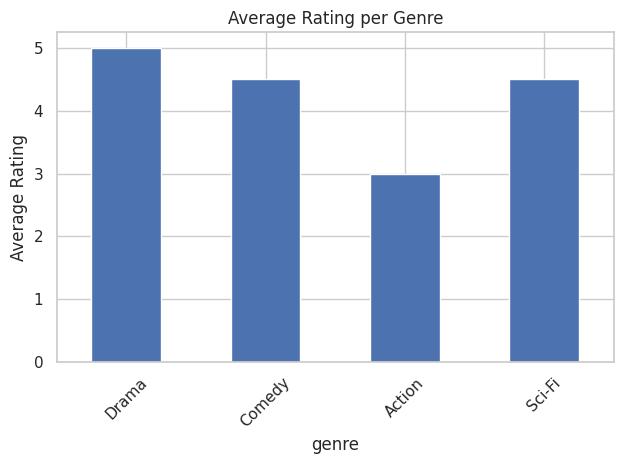

In [24]:
avg_rating_genre = ratings_df.join(movies_df, "movie_id") \
    .groupBy("genre") \
    .avg("rating") \
    .withColumnRenamed("avg(rating)", "avg_rating") \
    .toPandas()

avg_rating_genre.plot(kind="bar", x="genre", y="avg_rating", legend=False)
plt.ylabel("Average Rating")
plt.title("Average Rating per Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


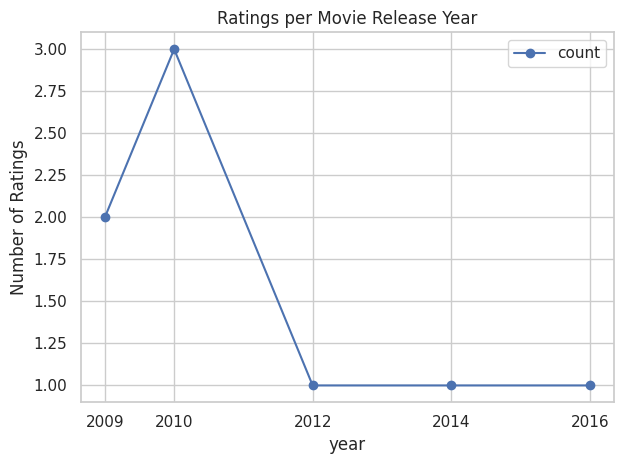

In [25]:
ratings_year = ratings_df.join(movies_df, "movie_id") \
    .groupBy("year") \
    .count() \
    .toPandas()

ratings_year.sort_values("year").plot(x="year", y="count", kind="line", marker='o')
plt.ylabel("Number of Ratings")
plt.title("Ratings per Movie Release Year")
plt.xticks(ratings_year['year'])
plt.grid(True)
plt.tight_layout()
plt.show()


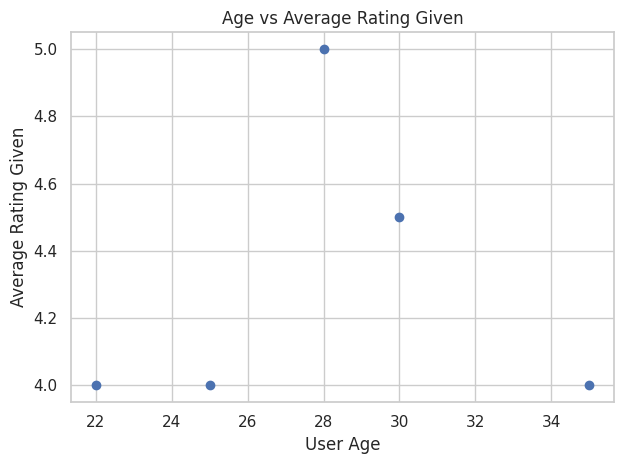

In [28]:
ratings_with_age = ratings_df.join(users_df, "user_id") \
    .groupBy("age") \
    .avg("rating") \
    .withColumnRenamed("avg(rating)", "avg_rating") \
    .toPandas()

plt.scatter(ratings_with_age["age"], ratings_with_age["avg_rating"])
plt.xlabel("User Age")
plt.ylabel("Average Rating Given")
plt.title("Age vs Average Rating Given")
plt.grid(True)
plt.tight_layout()
plt.show()
